# 2020. 02.03  AE, VAE, GAN 비지도 학습

# 번역망

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()
# encoding
#   0,1,2
# [S,E,P,....]

char_arr = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz단어나무놀이소녀연습사랑'] 
# 범주형 데이터
num_dic = {n:i for i, n in enumerate(char_arr)}  # enumerate : 각 단어에 번호달기
dic_len = len(num_dic)
print(dic_len) # 41
print(num_dic)

#  seq2seq 번역망    # 각 단어마다 4x41
seq_data = [['word','단어'], ['wood', '나무'],
            ['game','놀이'], ['gril','소녀'],
            ['test', '연습'], ['love','사랑']]


def make_batch(seq_data):
    input_batch = []
    output_batch = []
    target_batch = []
    
    for seq in seq_data:  # ['word', '단어']
        
        input = [num_dic[n] for n in seq[0]] # word =>  번호 25, 17, ..
        # 첫번째 입력되는 데이터는 'word'이 학습된 smoking gun
        output = [num_dic[n] for n in ('S'+ seq[1])]    # 훈련된 특징값 시작 으로  S 써준다
        target = [num_dic[n] for n in (seq[1]+'E')]  # 끝을 확인하기 위해서 E를 써준다. 
        
        # identity matrix  단위행렬 => one-hot-encoding
        # 1, 000000000...
        # 0, 1000000000..
        # 0,0,1,0000000....
        
        input_batch.append(np.eye(dic_len)[input])  # 25, 17,.. 번이 1번인 것 =>  2차원배열  (4x41)  # word
        output_batch.append(np.eye(dic_len)[output])  # 2x41
        target_batch.append(target)
    return input_batch, output_batch, target_batch

learning_rate = 0.01
n_hidden = 128 # neurons 출력이 128차
total_epoch = 100
n_class = n_input = dic_len

# encoder, decoder 용 데이터 주입변수
enc_input = tf.placeholder(tf.float32, [None, None, n_input])
dec_input = tf.placeholder(tf.float32, [None, None, n_input])
targets = tf.placeholder(tf.int64,[None, None])

# 영어
with tf.variable_scope('encode'):
    # FFNN 한개 :입력 -> 가중치 ->> 출력(n_hidden)
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)  # 입력 41 x128
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob = 0.5, seed = 100)
    # 과적합방지하기 위해 계산회로 생략 - randoom 하게 생략  ( dropout)
    
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype = tf.float32)
    # 4개의 step , 4개의 seq -> 1개의 히든레이어 cell셀이 4개, 셀당 4개의 step,  4개의 데이터가 입력
    
# 한글
with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden) # 128
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob = 0.5)
    
    # 2(한글 seq)x 42
    # 앞에 인코더망에서 출력된 states 값: 마지막 cell의 출력
    # 앞에 데이터를 다 고려한 특징
    # 두개의 망을 연결 : initial_state = enc_states
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input, initial_state = enc_states, dtype = tf.float32)
    
# outputs 6 배치 x 3 x 128   x nclass 41개
# 6x3x41
model = tf.layers.dense(outputs, n_class, activation = None)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = model, labels = targets))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

41
{'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '단': 29, '어': 30, '나': 31, '무': 32, '놀': 33, '이': 34, '소': 35, '녀': 36, '연': 37, '습': 38, '사': 39, '랑': 40}
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.


In [2]:
input_batch, output_batch, target_batch = make_batch(seq_data)
for epoch in range(total_epoch):  # 100회전
    _, loss = sess.run([optimizer, cost], feed_dict = {enc_input:input_batch,
                                                      dec_input: output_batch,
                                                      targets: target_batch})
    
    print('Epoch:', '%04d' % (epoch + 1), 'cost = ', '{:6f}'.format(loss))

Epoch: 0001 cost =  3.770077
Epoch: 0002 cost =  2.702893
Epoch: 0003 cost =  1.657136
Epoch: 0004 cost =  1.124581
Epoch: 0005 cost =  0.683558
Epoch: 0006 cost =  0.410239
Epoch: 0007 cost =  0.347343
Epoch: 0008 cost =  0.218123
Epoch: 0009 cost =  0.185779
Epoch: 0010 cost =  0.141519
Epoch: 0011 cost =  0.185513
Epoch: 0012 cost =  0.082373
Epoch: 0013 cost =  0.080650
Epoch: 0014 cost =  0.135361
Epoch: 0015 cost =  0.059066
Epoch: 0016 cost =  0.161791
Epoch: 0017 cost =  0.159700
Epoch: 0018 cost =  0.035740
Epoch: 0019 cost =  0.030924
Epoch: 0020 cost =  0.101821
Epoch: 0021 cost =  0.154780
Epoch: 0022 cost =  0.060690
Epoch: 0023 cost =  0.051391
Epoch: 0024 cost =  0.019062
Epoch: 0025 cost =  0.009330
Epoch: 0026 cost =  0.046847
Epoch: 0027 cost =  0.007137
Epoch: 0028 cost =  0.010666
Epoch: 0029 cost =  0.002824
Epoch: 0030 cost =  0.003718
Epoch: 0031 cost =  0.023760
Epoch: 0032 cost =  0.008117
Epoch: 0033 cost =  0.003189
Epoch: 0034 cost =  0.002545
Epoch: 0035 co

In [3]:
def translate(word): # word
    # 모델의 자리수는 일치 시켜야함
    seq_data = [word, 'P'* len(word)] # word, PPPP
    # 1x 4 x41    #1x 4x 41
    input_batch, output_batch, target_batch = make_batch([seq_data])
    prediction = tf.argmax(model,2) 
    # 면, 행, 열 : 2번째 열중심으로 가장 높은값 추출 : => 41개중 max
    # 1 x 5(E 붙인거) x 41
    result = sess.run(prediction, feed_dict={enc_input: input_batch,
                                             dec_input: output_batch,
                                            targets : target_batch})
    decoded = [char_arr[i] for i in result[0]] # result[0] 은 5개의    # 5 x 41
    end = decoded.index('E')
    translated = ''.join(decoded[:end])
    return translated

print('word ->', translate('word'))

# 단어의 끝을 표시하려고  end를 하고 출력할때는 보이지 않게

word -> 단어


# OCR  (CV2)

영수증 사진에서 텍스트 불러오기

In [4]:
# pip install opencv-python

import json
import cv2   # computer vision 이미지, 동영상 처리
import requests  # html 페이지 요청
import sys
LIMIT_PX = 1024 
LIMIT_BYTE = 1024*1024
LIMIT_BOX = 40



# OCR. 절차
# 이미지 사이즈 조정
# 글씨를 둘러싼 Box를 detection    (컬러가 있는 부분을 계속 박스로 만들다 없는 부분에서 스톱 => 하나의 이미지 찾음)



def kakao_ocr_resize(mage_path: str): # 규격이미지 사이즈
    image= cv2.imread('2.jpg')  # 자기의 이미지로 변경 : 영수증
    height, width, _ = image.shape
    if LIMIT_PX < height or LIMIT_PX < width:
        ratio = float(LIMIT_PX) / max(height, width)
        image = cv2.resize(image,None, fx = ratio, fy = ratio)
        height, width, _ = height, width, _ = image.shape
        image_path = "{}_resized.jpg".format('2')
        cv2.imwrite(image_path, image)        
        return image_path
    
    return None



# 사용버
# openapi 함수를 원격호출( remote call )

def kakao_ocr_detect(image_path: str, appkey:str):
    API_URL = 'https://kapi.kakao.com/v1/vision/text/detect'
    headers = {'Authorization': 'KakaoAK {}'.format('160da134fe8db35ceed28201ae832e9a')}
    # 이미지 로딩
    image = cv2.imread('2.jpg')
    # naver에서는 jpg 형식 사용. gif(애니매이션 지원),  png(transparent 지원)
    jpeg_image = cv2.imencode(".jpg", image)[1]
    data =jpeg_image.tobytes()  # 네트워크 전송 -> serialization
    # 네트워크 일 때 => 데이터가 시리얼로 가야함 (네트워크 모델)
    # 8개 line 으로 구성 => 4개 회선만 사용 -> 1개는 전송, 1개는 수신
    
    # 네트워크를 통해서 함수 호출(시간 필요) : 비동기 방식
    # 동기 방식: 호줄하면 기다리기    &   비동기 방식 :호출시키고 다른 작업을 하다가 event가 되ㅁ면 됨.
    # 대표적인 비동기 통신 방식으로 AJAX : 웹브라우저 내부적 처리
    # flask 에서 사용
    # 인터넷에서는 표준 데이터 포멧 : json
    return requests.post(API_URL, headers = headers, files = {"file": data})




def kakao_ocr_recognize(image_path: str, boxes: list, appkey: str):
    API_URL = 'https://kapi.kakao.com/v1/vision/text/recognize'
    headers = {'Authorization': 'KakaoAK {}'.format('160da134fe8db35ceed28201ae832e9a')}   
    image = cv2.imread('2.jpg')
    jpeg_image = cv2.imencode('.jpg', image)[1]
    data = jpeg_image.tobytes() 
    # OCR, 인식은 Box 로 텍스트 구역을 확인하고
    # recognize 인식한다.
    
    return requests.post(API_URL, headers=headers,
                        files={"file": data}, data={"boxes": json.dumps(boxes)})


# 자동 가계부
def main():
    image_path, appkey = sys.argv[0], sys.argv[0]
    resize_impath = kakao_ocr_resize(image_path)
    output = kakao_ocr_detect(image_path, appkey).json()
    boxes = output["result"]["boxes"]
    boxes = boxes[:min(len(boxes), LIMIT_BOX)]
    output = kakao_ocr_recognize(image_path, boxes, appkey).json()
    return output

output = main()
output["result"] # 글씨로 변환된 결과 출력

# 코드소스
# https://developers.kakao.com/docs/restapi/vision#OCR
    

{'recognition_words': ['123456789',
  'TEL:042',
  '대표:이종선',
  '대젊.라맛동',
  '[홍원범활이160닝5초2',
  'quest',
  '201607220449',
  '17:01:40',
  '항',
  '목',
  '금',
  '액',
  '.',
  '결제금액',
  '1000',
  '카드영수증',
  '출영',
  '꽃데물:',
  '1000',
  '0',
  'BAC',
  'WPOS',
  '1666-9115']}

# 동영상

In [62]:
# 동영상 실행

import cv2
import numpy as np
# cap =  cv2.VideoCapture(0)  0번 디바이스 - 카메라 영상을 받아 들임
cap =  cv2.VideoCapture("corrupted_video.mp4")
if (cap.isOpened()==False):  # 파일이 없거나 장치가 없거나
    print("에러 발생")
while(cap.isOpened()):
    ret, frame = cap.read()  # 1개의 frame => 동영상은 ntsc 방식 초당 29.7 프레임 이미지를 불러와서 동영상됨
    if ret == True:
        cv2.imshow('Frame', frame)  # 이미지 출력
        # 16진수 15, esc
        if cv2.waitKey(25) & 0xFF == ord('q'): # ascii code 코드표
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

In [63]:
# 동영상 저장
# 동영상 데이터 전처리 => AI model 훈련 => 실시간 인식

import numpy as np
import cv2  # computer vision 처리 -> 사운드 불가
cap =  cv2.VideoCapture("corrupted_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # codec 을 가지고 있지 않는다 -> 그래서 codec 설치 필요
                                          # codec : 동영상 encoding + decoding
    
out = cv2.VideoWriter('output.avi', fourcc, 20.0, ( 640, 480))
while(cap.isOpened()):
    ret, frame = cap.read()  # embeded 장치  ai npu (<-삼성 엑시노스) 달고 처리..
    if ret == True:
        frame = cv2.flip(frame,0)  # flip : 영상 뒤집기
        # 자동 차선인식, object detection 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # 회색으로 고속  (이 코드 지우면 컬러)
        
        out.write(frame)  # 저장
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

In [66]:
# 배경제거

import cv2
import numpy as np
history = 30

cap =  cv2.VideoCapture("corrupted_video.mp4")
if (cap.isOpened()==False): 
    print("에러 발생")
    
fgbg = cv2.createBackgroundSubtractorMOG2() # backgroundfilter

# 회색(제거)
while(cap.isOpened()):
    ret, frame = cap.read()  
    if ret == True:
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgmask = fgbg.apply(gray, learningRate = 1.0/history)
        cv2.imshow('Frame', fgmask)    # 이미지 출력-> fgmask 로 호출되서 회색으로 나온다
        
        if cv2.waitKey(25) & 0xFF == ord('q'): 
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

# AE (autoencoder)

denoising autoencoder
- 원본, noise가 있는 학습 데이터
- 학습은 noise가 있는 학습 데이터 => 가중치
- autoencoder는 denosing을 한다.      
노이지가 있는 데이터여도 학습하고 나올때는 원본처럼 나오다.(denoising)   
원본 이미지...

In [69]:
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as  gridspec

# denoising autoencoder
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows, n_image_cols, top=1.,
                          bottom=0., right = 1., left = 0., hspace=0., wspace =0.)
    
    for g, count in zip(gs, range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.savefig(save_name + '_vis.png')
    plt.show()
    
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500

In [72]:
import tensorflow as tf

corruption_level = 0.3

# 입력데이터와 mask 만 있음(target 는 없음 : 자기자신 학습)
# 784
X = tf.placeholder("float", [None, n_visible], name='X')
mask = tf.placeholder("float", [None, n_visible], name= 'mask')

W_init_max = 4 * np.sqrt(6./(n_visible + n_hidden))

# 균등 분포에서 데이터 생성 (가중치 초기화)
W_init = tf.random_uniform(shape = [n_visible, n_hidden], minval = -W_init_max, maxval = W_init_max)

W = tf.Variable(W_init, name = 'W')
b = tf. Variable(tf.zeros([n_hidden]), name = 'b')

In [73]:
W_prime = tf.transpose(W)   # 자기 자신의 전치된 데이터 
b_prime = tf.Variable(tf.zeros([n_visible]), name = 'b_prime') 

def model (X, mask, W, b, W_prime, b_prime):
    
    tilde_X = mask * X  # 원본 * 마스크 : 행렬 요소곱
    
    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W)+b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    return Z

Z = model(X, mask, W, b, W_prime, b_prime)
# 가중치에 이미지의 특성이 추출  (denoising)

In [75]:
# 비지도 학습 :데이터의 특징 뽑아내기 : PCA 데이터 재해석( 직교하는 축으로)
# 원본 데이터 X == 예측된 데이터 Z  ( 자기자신)
# autoencoder input : 자기자신 == output도 자기자신
# nois : 군데군데 틈(구멍) : 구멍이 나도 원본의 특징을 추출

                           # 결과
cost = tf.reduce_sum(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)
predict_op =Z

mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ub

0 111499.625
1 95485.13
2 85510.53
3 81326.39
4 78601.71
5 74656.71
6 73370.11
7 72166.234
8 69839.36
9 67651.83
10 67101.93
11 67020.65
12 66764.2
13 65075.88
14 65935.125
15 64773.492
16 63870.645
17 63697.824
18 62819.094
19 62870.258
20 63030.96
21 62473.71
22 61045.85
23 62142.26
24 60528.523
25 61478.992
26 60764.754
27 61491.16
28 60751.152
29 60419.684
30 60620.83
31 60012.57
32 60844.355
33 59476.29
34 59618.426
35 61128.32
36 60116.695
37 59960.02
38 59422.977
39 58787.695
40 59496.99
41 58316.066
42 58745.21
43 59942.594
44 58933.797
45 57958.477
46 57989.27
47 58512.93
48 58422.49
49 58942.32
50 58137.113
51 57813.12
52 57984.53
53 57918.938
54 58412.82
55 57896.99
56 57763.312
57 58063.18
58 58509.777
59 57486.39
60 58337.133
61 57795.562
62 57476.414
63 57747.79
64 59051.754
65 57980.312
66 57481.824
67 58010.324
68 57411.105
69 57548.668
70 56724.996
71 57818.96
72 56598.617
73 57186.305
74 56968.543
75 56905.53
76 56796.61
77 57110.797
78 56752.676
79 56903.504
80 57668

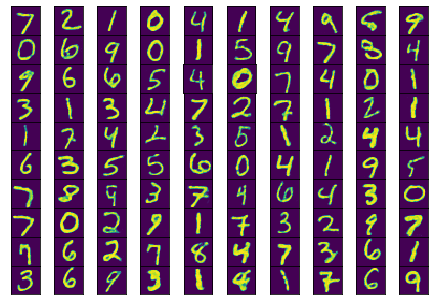

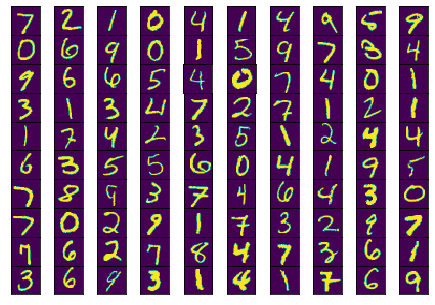

In [81]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(100):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            input_ = trX[start:end]
            
            mask_np = np.random.binomial(1, 1 - corruption_level,input_.shape )
            # 입력데이터 target 없음
            sess.run(train_op, feed_dict={X:input_, mask:mask_np})
             
            
        # 이항분포로 마스크 생성 <- 노이즈를 주기위해 (원본이미지에)    
        mask_np = np.random.binomial(1,1 - corruption_level, teX.shape)
        
        print(i, sess.run(cost, feed_dict={X:teX, mask:mask_np}))
        
    mask_np = np.random.binomial(1, 1 - corruption_level, teX[:100].shape)
    # 예측할 때 이미지에 
    predicted_imgs = sess.run(predict_op, feed_dict = {X:teX[:100], mask: mask_np})
        
    input_imgs = teX[:100]
vis(predicted_imgs, 'pred') #예측된 이미지
vis(input_imgs, 'in') # 입력이미지

# Variational autocoder (VAE)
 판별 모델 ( discrimitive model)  : 선을 그어서 분류   
            
 
 생성 모델 (generative model) : 확륙을 찾아낸다 ( 평균 + 분산  => 분포)
     -  잠재변수 (latent variables) : 이미지를 보고 특성을 잡아내는것 (키, 나이, 성별.. 등등)  => 특징 생성
     -  잠재변수의 특징 + 노이즈 : ( 분산이 있는 특징을 뽑을 수 있다 )
     => class 생성

In [90]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

train, test = tf.keras.datasets.mnist.load_data()
train_x, train_y = train

from functools import partial

n_inputs = 28 * 28  # 784
n_hidden1 = 500 
n_hidden2 = 500
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs  # 입력이 출력으로 
learning_rate = 0.001

# without scaling 초기화
initializer = tf.contrib.layers.variance_scaling_initializer()

11493376/11490434 [==============================] - 1s 0us/step


In [91]:
my_dense_layer = partial( # partial: 매개변수 일부를 고정  (뒤에 나오는 걸 상수화한다)
    tf.layers.dense, activation = tf.nn.elu, kernel_initializer = initializer)
# elu : exponential linear unit : (-1을 고려한 relu)

X = tf.placeholder(tf.float32, [None, n_inputs])

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)

# 분포학습?
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation = None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation = None)

noise = tf.random_normal(tf.shape(hidden3_sigma), dtype = tf.float32)

# 평균, 분산 * 노이즈 (변동된 특성 추출)
hidden3 = hidden3_mean + hidden3_sigma * noise  # 요소 곱

hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)

# 자기자신 값  28 * 28 = 784
logits = my_dense_layer(hidden5, n_outputs, activation = None)
outputs = tf.sigmoid(logits)

In [92]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = X, logits=logits)  # 입력값 == 출력값
# 입력값이 출력값이 되도록 가중치를 준다
# 가중치가 이 데이터의 특성이 된다

# 1. 재구축 손실
reconstruction_loss = tf.reduce_sum(xentropy)
eps = 1e-10 # eps : epsilon 상수 : 로그의  성질(0이면 무한대) 를 방지. 
# epsilon 상수: 부동소수점을 비교 0.0001 차가 0.0001이하이면 같은것으로 본다.


# 2. 지연 손실
# cost function :
latent_loss = 0.5 * tf.reduce_sum(    # log liklihodd 우도 확률
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
                                 -1 - tf.log(eps + tf.square(hidden3_sigma)))

# 1.+ 2.
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [93]:
import sys

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end = "")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            sess.run(training_op, feed_dict={X:X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, 
                                                                      latent_loss], feed_dict = {X:X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val,
              "\tLatent loss:", latent_loss_val)
        codings_rnd = np.random.normal(size = [n_digits, n_hidden3])
        outputs_val = outputs.eval(feed_dict = {hidden3: codings_rnd})
        
# 가중치를 통과한 데이터 ( test ): 모델 완성
# PCA 처럼 비지도 학습의 특성으로 추출된 데이터( 분류와 예측 )


0 Train total loss: 29041.418 	Reconstruction loss: 24588.691 	Latent loss: 4452.7266
1 Train total loss: 26863.54 	Reconstruction loss: 21768.17 	Latent loss: 5095.37
2 Train total loss: 27144.506 	Reconstruction loss: 22453.756 	Latent loss: 4690.7495
3 Train total loss: 21206.947 	Reconstruction loss: 18502.992 	Latent loss: 2703.9556
4 Train total loss: 23285.045 	Reconstruction loss: 19911.36 	Latent loss: 3373.686
5 Train total loss: 20933.982 	Reconstruction loss: 17928.389 	Latent loss: 3005.5938
6 Train total loss: 19248.316 	Reconstruction loss: 16093.959 	Latent loss: 3154.3574
7 Train total loss: 18242.559 	Reconstruction loss: 15108.4795 	Latent loss: 3134.0781
8 Train total loss: 16532.994 	Reconstruction loss: 13384.109 	Latent loss: 3148.8855
9 Train total loss: 16423.271 	Reconstruction loss: 13185.756 	Latent loss: 3237.516
10 Train total loss: 16944.363 	Reconstruction loss: 13586.945 	Latent loss: 3357.4175
11 Train total loss: 16243.08 	Reconstruction loss: 12735.7

 2020.02.04

# GAN

In [1]:
# https://github.com/golbin/TensorFlow-Tutorials/blob/master/09%20-%20GAN/01%20-%20GAN.py
# 꼭 보기! 동일 코드 (GAN 설명)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

In [2]:
total_epoch = 100
batch_size = 100
learning_rate = 0.0002
n_hidden = 256
n_input = 28*28
n_noise = 128

X = tf.placeholder(tf.float32, [None, n_input])  # 실제 데이터 입력
Z = tf.placeholder(tf.float32, [None, n_noise])  # 노이즈 입력

In [8]:
# 가중치

# 128 x 256
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))

# 256x784
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))

D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01))
D_b2 = tf.Variable(tf.zeros([1]))

In [9]:
# 생성기 와 판별기
# cost function : 확률적 함수
# MSE, Enthropy 분류

# Kullback-lieber
# KL-Divergence : GAN, VAE - 분포의 차를 확인하는 함수
# 생성기 -> noise가 input 데이터, cost function : KL-Divergence


def generator(noise_z):  # 128x128
    hidden = tf.nn.relu(tf.matmul(noise_z, G_W1)+G_b1)  # 128x256
    output = tf.nn.sigmoid(tf.matmul(hidden, G_W2) + G_b2) # 128x784
    return output # 784 이미지 생성

# 판별 (가중치 학습)
def discriminator(inputs): # 실제의 분포를 확인
    hidden = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden, D_W2)+ D_b2)
    return output

def get_noise(batch_size, n_noise):
    return np.random.normal(size = (batch_size, n_noise))

생성자가 만든 이미지를 구분자가 가짜라고 판단하도록 하는 손실값(경찰용)과     
진짜라고 판단하도록 하는 손실값(위조지폐범용)을 구해야 한다.    
경찰을 학습시키려면 진짜 이미지 판별값 D_real은 1에 가까워애하고 (진짜라고 판별), 가짜 이미지 판별값(D_gene)는 0엥 가까워야 한다(가짜라고 판멸)
           
그래서 'D_real'과 '1-D_gene'를 더한 값을 손실값으로 해서 이 값을 최대화 하면 경찰 학습이 이뤄진다      
그리고 가짜 이미지 판별값 D_gene를 1에 가깝게 만들면 된다.(최대화) (위조용)

In [10]:
# https://books.google.co.kr/books?id=GXg3DwAAQBAJ&pg=PA154&lpg=PA154&dq=loss_D+%3D+tf.reduce_mean(tf.log(D_real)+%2B+tf.log(1+-+D_gene))&source=bl&ots=D6TOeU3s_J&sig=ACfU3U3N7KFcAKmfUZqoxnjfmNaYAg2Iaw&hl=ko&sa=X&ved=2ahUKEwiUjLuT5LbnAhWBP3AKHeX2BSwQ6AEwAnoECAoQAQ#v=onepage&q=loss_D%20%3D%20tf.reduce_mean(tf.log(D_real)%20%2B%20tf.log(1%20-%20D_gene))&f=false
# 골빈해커 설명

G = generator(Z)   # 노이지 => 이미지생성

D_gene = discriminator(G)  # 이미지를 판별 : 분포를 확인한다
D_real = discriminator(X)  # 실제 이미지의 분포를 확인


# 논문에 따르면, GAN 모델의 최적화는 loss_G 와 loss_D 를 최대화 하는 것 입니다.
# 다만 loss_D와 loss_G는 서로 연관관계가 있기 때문에 두 개의 손실값이 항상 같이 증가하는 경향을 보이지는 않을 것 입니다.
# loss_D가 증가하려면 loss_G는 하락해야하고, loss_G가 증가하려면 loss_D는 하락해야하는 경쟁관계에 있기 때문입니다.
# 논문의 수식에 따른 다음 로직을 보면 loss_D 를 최대화하기 위해서는 D_gene 값을 최소화하게 됩니다.
# 판별기에 진짜 이미지를 넣었을 때에도 최대값을 : tf.log(D_real)
# 가짜 이미지를 넣었을 때에도 최대값을 : tf.log(1 - D_gene)
# 갖도록 학습시키기 때문입니다.
# 이것은 판별기는 생성기가 만들어낸 이미지가 가짜라고 판단하도록 판별기 신경망을 학습시킵니다.

loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene))

# 반면 loss_G 를 최대화하기 위해서는 D_gene 값을 최대화하게 되는데,
# 이것은 가짜 이미지를 넣었을 때, 판별기가 최대한 실제 이미지라고 판단하도록 생성기 신경망을 학습시킵니다.
# 논문에서는 loss_D 와 같은 수식으로 최소화 하는 생성기를 찾지만,
# 결국 D_gene 값을 최대화하는 것이므로 다음과 같이 사용할 수 있습니다.


loss_G = tf.reduce_mean(tf.log(D_gene))  # 최대우도 추정법 - 적합한 분포가 될수 있도록 로그로 평균 계산
# log 확률값 => 정보량을 구한다
# 확률이 높아지면 정보량이 작아지고 확률이 낮아지면 정보량이 커진다. (tfidf의 논리를 고려할 것)
# 가장 적합한 분포 -> 높은 것이 유리


D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]

# GAN 논문의 수식에 따르면 loss 를 극대화 해야하지만, minimize 하는 최적화 함수를 사용하기 때문에
# 최적화 하려는 loss_D 와 loss_G 에 음수 부호를 붙여줍니다.
# 최대화 하기 위해 - (거꾸로 - 값을 넣음)
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list=D_var_list)  # 역전파 변수를 지정
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list=G_var_list)  # 

%matplotlib inline
sess = tf.Session()
sess.run(tf.global_variables_initializer())
total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

In [20]:
# 이미지 분포의 특징을 추출하는 망
# 노이지를 줌으로써 점점 선명해짐
for epoch in range(total_epoch):
    for i in range(total_batch):
        
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)
        
        # 실제 이미지 분포
        _, loss_val_D = sess.run([train_D, loss_D],
                                feed_dict={X:batch_xs, Z:noise})
        # 이미지를 생성 128x128 
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Z: noise})
                
            
    print('Epoch:', '%04d' % epoch, ' D loss: {:.4}'.format(loss_val_D),
          'G loss :{:.4}'.format(loss_val_G))
    
    if epoch ==0 or (epoch +1) % 10 == 0:
        sample_size =10
        # 노이즈 로부터 이미지를 생성 :  generator 
        noise = get_noise(sample_size, n_noise)  # 10 x 128
        samples = sess.run(G, feed_dict={Z: noise})
        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
        
        
        for i in range(sample_size):
            ax[i].set_axis_off()  # 128 => 784 이미지 사이즈로 생성
            ax[i].imshow(np.reshape(samples[i], (28,28)))
        
        plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)
    
print('최적화완료')    

Epoch: 0000  D loss: -0.7832 G loss :-1.778
Epoch: 0001  D loss: -0.8261 G loss :-1.718
Epoch: 0002  D loss: -0.6911 G loss :-2.034
Epoch: 0003  D loss: -0.8654 G loss :-1.657
Epoch: 0004  D loss: -0.8464 G loss :-1.862
Epoch: 0005  D loss: -0.7971 G loss :-1.969
Epoch: 0006  D loss: -0.7046 G loss :-2.076
Epoch: 0007  D loss: -0.804 G loss :-2.046
Epoch: 0008  D loss: -0.8187 G loss :-1.72
Epoch: 0009  D loss: -0.7677 G loss :-1.921
Epoch: 0010  D loss: -0.8433 G loss :-1.791
Epoch: 0011  D loss: -0.7417 G loss :-1.904
Epoch: 0012  D loss: -0.7917 G loss :-1.958
Epoch: 0013  D loss: -0.8065 G loss :-1.77
Epoch: 0014  D loss: -0.9054 G loss :-1.769
Epoch: 0015  D loss: -0.9988 G loss :-1.794
Epoch: 0016  D loss: -0.8064 G loss :-1.739
Epoch: 0017  D loss: -0.9338 G loss :-1.83
Epoch: 0018  D loss: -0.8102 G loss :-1.895
Epoch: 0019  D loss: -0.8917 G loss :-1.737
Epoch: 0020  D loss: -0.8011 G loss :-1.81
Epoch: 0021  D loss: -0.848 G loss :-1.595
Epoch: 0022  D loss: -0.8207 G loss :-